In [2]:
# import neccessary dependencies
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import joblib
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import joblib

# Import the data

In [3]:
# training data
train = pd.read_csv(r".\hatespeech\train.csv", nrows=10000)

# testing data
test = pd.read_csv(r".\hatespeech\test.csv", nrows=10000)


# Clean the data of null values

In [4]:
# drop rows with null values
train.dropna()

,text,label
0,Inaasahan na ni Vice President Jejomar Binay n...,0
1,Mar Roxas TANG INA TUWID NA DAAN DAW .. EH SYA...,1
2,Salamat sa walang sawang suporta ng mga taga m...,0
3,@rapplerdotcom putangina mo binay TAKBO PA,1
4,"Binay with selective amnesia, forgetting about...",0
...,...,...
9995,"Mar Roxas on the rise, w/ momentum, machinery,...",0
9996,@chelseapailmao,1
9997,"Alan Cayetano 'confirms' Palace, Roxas, Poe be...",0
9998,Mas nakakainis ad ni Mar kaysa kay Binay.,1


In [5]:
#check for null values in train
train.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
# check for 0 values in train
sum(train["label"] == 0)

5340

In [7]:
# check for 1 values in train
sum(train["label"] == 1)

4660

# Clean the data of unwated Text and Characters

In [8]:
# remove special characters using the regular expression library

import re

#set up punctuations we want to be replaced

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

In [9]:
import preprocessor as p

# custum function to clean the dataset (combining tweet_preprocessor and reguar expression)
def clean_tweets(df):
    tempArr = []
    for line in df:
        # send to tweet_processor
        tmpL = p.clean(line)
        # remove everything except letters and digits
        tmpL = re.sub(r'[^a-zA-Z0-9\s]', ' ', tmpL)
        # convert to lowercase
        tmpL = tmpL.lower()
        tempArr.append(tmpL)
    return tempArr

In [10]:
# clean training data
train_tweet = clean_tweets(train["text"])
train_tweet = pd.DataFrame(train_tweet)

In [11]:
# append cleaned tweets to the training data
train["clean_tweet"] = train_tweet


In [12]:
sum(train['clean_tweet'] == '')

494

In [13]:
#df['Another'] = df['Another'].replace('', np.nan)
#replace all empty spaces with NaN to drop using dropna
train['clean_tweet'] = train['clean_tweet'].replace('', np.NaN)

In [14]:
train.dropna(axis='rows')

,text,label,clean_tweet
0,Inaasahan na ni Vice President Jejomar Binay n...,0,inaasahan na ni vice president jejomar binay n...
1,Mar Roxas TANG INA TUWID NA DAAN DAW .. EH SYA...,1,mar roxas tang ina tuwid na daan daw eh sya...
2,Salamat sa walang sawang suporta ng mga taga m...,0,salamat sa walang sawang suporta ng mga taga m...
3,@rapplerdotcom putangina mo binay TAKBO PA,1,putangina mo binay takbo pa
4,"Binay with selective amnesia, forgetting about...",0,binay with selective amnesia forgetting about...
...,...,...,...
9994,kaninang pa itong Binay binay binay.....tch,1,kaninang pa itong binay binay binay tch
9995,"Mar Roxas on the rise, w/ momentum, machinery,...",0,mar roxas on the rise w momentum machinery ...
9997,"Alan Cayetano 'confirms' Palace, Roxas, Poe be...",0,alan cayetano confirms palace roxas poe be...
9998,Mas nakakainis ad ni Mar kaysa kay Binay.,1,mas nakakainis ad ni mar kaysa kay binay


In [15]:
#https://statisticsglobe.com/drop-rows-blank-values-from-pandas-dataframe-python
train['clean_tweet'] = train['clean_tweet'].replace('', float('NaN'), regex = True)

In [16]:
train.dropna(inplace= True)
train = train.reset_index(drop=True)

In [17]:
first_column = train.pop('label')
train.insert(0,'label',first_column)

In [18]:
#total data entries for training

print(train.shape)

(9506, 3)


In [19]:
# check for 0 values in train
sum(train["label"] == 0)

5030

In [20]:
# check for 1 values in train
sum(train["label"] == 1)

4476

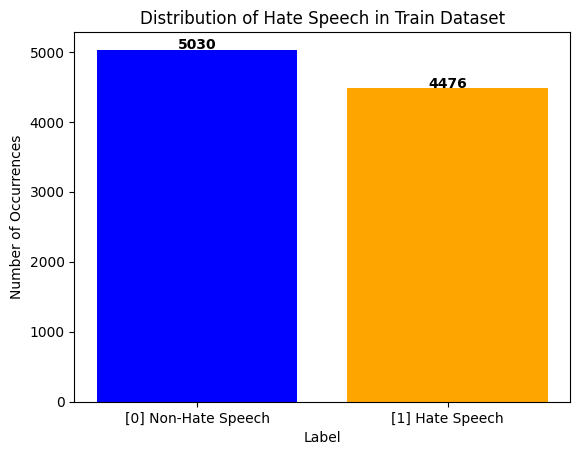

In [38]:
import matplotlib.pyplot as plt

# count the number of occurrences of 0 and 1 in the "label" column
num_non_hate_speech = sum(train["label"] == 0)
num_hate_speech = sum(train["label"] == 1)

# create a bar plot with different colors for each bar
plt.bar(["[0] Non-Hate Speech", "[1] Hate Speech"], [num_non_hate_speech, num_hate_speech],
        color=["blue", "orange"])

# set the title and axis labels
plt.title("Distribution of Hate Speech in Train Dataset")
plt.xlabel("Label")
plt.ylabel("Number of Occurrences")

# display the exact value on top of the bar
for i, v in enumerate([num_non_hate_speech, num_hate_speech]):
    plt.text(i, v+10, str(v), color='black', fontweight='bold', ha='center')

# display the plot
plt.show()


In [21]:
#remove stopwords
import urllib.request, json 
with urllib.request.urlopen("https://raw.githubusercontent.com/stopwords-iso/stopwords-tl/master/stopwords-tl.json") as url:
    stopwords = json.loads(url.read().decode())
    print(stopwords)

['akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'bababa', 'bago', 'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito', 'doon', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka', 'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang', 'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan', 'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod', 'lima', 'maaari', 'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin', 'napaka', 'narito', 'nasaan', 'ng', 'ngayon', 'ni', 'nila',

In [22]:
#data['content2'] =data['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
train['rm_stpwrds'] = train['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords) ]))

In [23]:
#tokenization 

import nltk
from nltk.tokenize import WhitespaceTokenizer
train['tokenize'] = train['rm_stpwrds'].apply(nltk.tokenize.WhitespaceTokenizer().tokenize) 
train['tokenize'].head()



0    [inaasahan, vice, president, jejomar, binay, t...
1    [mar, roxas, tang, ina, tuwid, daan, daw, eh, ...
2    [salamat, sawang, suporta, taga, makati, pagba...
3                        [putangina, mo, binay, takbo]
4    [binay, with, selective, amnesia, forgetting, ...
Name: tokenize, dtype: object

In [24]:
from nltk.stem.wordnet import WordNetLemmatizer
def lema_words(text):
  wnl=WordNetLemmatizer()
  return[wnl.lemmatize(w) for w in text]

train['lematize_nltk']=train['tokenize'].apply(lema_words)  
train[['tokenize','lematize_nltk']].sample(5)

,tokenize,lematize_nltk
4696,"[kainis, mukha, binay, luuh, sge, maglibot, bu...","[kainis, mukha, binay, luuh, sge, maglibot, bu..."
4665,"[the, binay, challenge, hahahahaha]","[the, binay, challenge, hahahahaha]"
5590,"[woahh, mar, roxas, gain, so, fastttttttttttttt]","[woahh, mar, roxas, gain, so, fastttttttttttttt]"
8996,"[ba, meron, pag, yan, kwenta, paguuntugin, kay...","[ba, meron, pag, yan, kwenta, paguuntugin, kay..."
7640,"[naiirita, advertisement, binay]","[naiirita, advertisement, binay]"


# Proceeding to Training

In [25]:
VOWELS = "aeiouAEIOU"
CONSONANTS = "bcdfghklmnngpqrstvwyBCDFGHKLMNNGPQRSTVWY"

""" 
	Affixes
"""
PREFIX_SET = [
	'nakikipag', 'pakikipag',
	'pinakama', 'pagpapa',
	'pinagka', 'panganga', 
	'makapag', 'nakapag', 
	'tagapag', 'makipag', 
	'nakipag', 'tigapag',
	'pakiki', 'magpa',
	'napaka', 'pinaka',
	'ipinag', 'pagka', 
	'pinag', 'mapag', 
	'mapa', 'taga', 
	'ipag', 'tiga', 
	'pala', 'pina', 
	'pang', 'naka',
	'nang', 'mang',
	'sing',
	'ipa', 'pam',
	'pan', 'pag',
	'tag', 'mai',
	'mag', 'nam',
	'nag', 'man',
	'may', 'ma',
	'na', 'ni',
	'pa', 'ka',
	'um', 'in',
	'i',
]

INFIX_SET = [
	'um', 'in',
]

SUFFIX_SET = [
	'syon','dor', 
	'ita', 'han', 
	'hin', 'ing', 
	'ang', 'ng', 
	'an', 'in', 
	'g',
]

PERIOD_FLAG = True
PASS_FLAG = False

def check_vowel(substring):
	"""
		Checks if the substring is a vowel.
			letters: substring to be tested
		returns BOOLEAN
	"""

	return all(letter in VOWELS for letter in substring)


def check_consonant(substring):
	"""
		Checks if the letter is a consonant.
			letter: substring to be tested
		returns BOOLEAN
	"""

	return all(letter in CONSONANTS for letter in substring)

def change_letter(token, index, letter):
	"""
		Replaces a letter in a token.
			token: word to be used
			index: index of the letter
			letter: letter used to replace
		returns STRING
	"""
	
	_list = list(token)
	_list[index] = letter

	return ''.join(_list)

def count_vowel(token):
	"""
		Count vowels in a given token.
			token: string to be counted for vowels
		returns INTEGER
	"""

	count = 0

	for tok in token:
		if check_vowel(tok):
			count+=1

	return count


def count_consonant(token):
	"""
		Count consonants in a given token.
			token: string to be counted for consonants
		returns INTEGER
	"""

	count = 0

	for tok in token:
		if check_consonant(tok):
			count+=1

	return count


def check_validation(token):
    with open('stemmer/validation.txt', 'r') as valid:
        data = valid.read().replace('\n', ' ').split(' ')

    return token in data


def clean_repetition(token, REPETITION):
	"""
		Checks token for repetition. (ex. nakakabaliw = nabaliw)
			token: word to be stemmed repetition
		returns STRING
	"""

	if check_validation(token):
		return token

	if len(token) >= 4:
		if check_vowel(token[0]):
			if token[0] == token[1]:
				REPETITION.append(token[0])
				return token[1:]

		elif check_consonant(token[0]) and count_vowel(token) >= 2:
			if token[0: 2] == token[2: 4] and len(token) - 2 >= 4:
				REPETITION.append(token[2:4])
				return token[2:]
			
			elif token[0: 3] == token[3: 6] and len(token) - 3 >= 4:
				REPETITION.append(token[3:6])
				return token[3:]

	return token

def clean_suffix(token, SUFFIX):
    """
    Checks token for suffixes. (ex. bigayan = bigay)
        token: word to be stemmed for suffixes
    returns STRING
    """

    SUF_CANDIDATE = []

    if check_validation(token):
        return token

    for suffix in SUFFIX_SET:
        if len(token) - len(suffix) >= 3 and count_vowel(token[0:len(token) - len(suffix)]) >= 2 and count_consonant(token[0:len(token) - len(suffix)]) >= 1:
            if token[len(token) - len(suffix): len(token)] == suffix:
                if len(suffix) == 2 and not count_consonant(token[0:len(token) - len(suffix)]) >= 1:
                    continue

                if count_vowel(token[0: len(token) - len(suffix)]) >= 2:
                    if suffix == 'ang' and check_consonant(token[-4]) \
                            and token[-4] != 'r' and token[-5] != 'u':
                        continue

                    #print(token[0: len(token) - len(suffix)] + " : " + suffix)

                    if check_validation(token[0: len(token) - len(suffix)]):
                        SUFFIX.append(suffix)
                        return token[0: len(token) - len(suffix)] + 'a' if suffix == 'ita' \
                            else token[0: len(token) - len(suffix)]

                    elif len(SUF_CANDIDATE) == 0:
                        SUF_CANDIDATE.append(suffix)
                        SUF_CANDIDATE.append(token[0: len(token) - len(suffix)])

    if (len(SUF_CANDIDATE) == 2):
        SUFFIX = SUF_CANDIDATE[0]
        return SUF_CANDIDATE[1][0: len(token) - len(SUFFIX)] + 'a' if SUFFIX == 'ita' \
            else SUF_CANDIDATE[1][0: len(token) - len(SUFFIX)]

    return token


def clean_infix(token, INFIX):
	"""
		Checks token for infixes. (ex. bumalik = balik)
			token: word to be stemmed for infixes
		returns STRING
	"""

	if check_validation(token):
		return token

	for infix in INFIX_SET:
		if len(token) - len(infix) >= 3 and count_vowel(token[len(infix):]) >= 2:
			if token[0] == token[4] and token[1: 4] == infix:
				INFIX.append(infix)
				return token[4:]

			elif token[2] == token[4] and token[1: 3] == infix:
				INFIX.append(infix)
				return token[0] + token[3:]

			elif token[1: 3] == infix and check_vowel(token[3]):
				INFIX.append(infix)
				return token[0] + token[3:]

	return token


def clean_prefix(token,	 PREFIX):
	"""
		Checks token for prefixes. (ex. naligo = ligo)
			token: word to be stemmed for prefixes
		returns STRING
	"""

	if check_validation(token):
		return token

	for prefix in PREFIX_SET:
		if len(token) - len(prefix) >= 3 and \
			count_vowel(token[len(prefix):]) >= 2:

			if prefix == ('i') and check_consonant(token[2]):
				continue

			if '-' in token:	
				token = token.split('-')

				if token[0] == prefix and check_vowel(token[1][0]):
					PREFIX.append(prefix)
					return token[1]

				token = '-'.join(token)

			if token[0: len(prefix)] == prefix:
				if count_vowel(token[len(prefix):]) >= 2:
					# if check_vowel(token[len(token) - len(prefix) - 1]):
				# 	continue

					if prefix == 'panganga':
						PREFIX.append(prefix)
						return 'ka' + token[len(prefix):]
					
					PREFIX.append(prefix)
					return token[len(prefix):]

	return token


def clean_duplication(token, DUPLICATE):
	"""
		Checks token for duplication. (ex. araw-araw = araw)
			token: word to be stemmed duplication
		returns STRING
	"""

	if check_validation(token):
		return token

	if '-' in token and token.index('-') != 0 and \
		token.index('-') != len(token) -  1:

		split = token.split('-')

		if all(len(tok) >= 3 for tok in split):
			if split[0] == token[1] or split[0][-1] == 'u' and change_letter(split[0], -1, 'o') == split[1] or \
				split[0][-2] == 'u' and change_letter(split[0], -2, 'o')  == split[1]:
				DUPLICATE.append(split[0])
				return split[0]

			elif split[0] == split[1][0:len(split[0])]:
				DUPLICATE.append(split[1])
				return split[1]

			elif split[0][-2:] == 'ng':
				if split[0][-3] == 'u':
					if split[0][0:-3] + 'o' == split[1]:
						DUPLICATE.append(split[1])
						return split[1]

				if split[0][0:-2] == split[1]:
					DUPLICATE.append(split[1])
					return split[1]

		else:
			return '-'.join(split)
	
	return token


def clean_repetition(token, REPETITION):
	"""
		Checks token for repetition. (ex. nakakabaliw = nabaliw)
			token: word to be stemmed repetition
		returns STRING
	"""

	if check_validation(token):
		return token

	if len(token) >= 4:
		if check_vowel(token[0]):
			if token[0] == token[1]:
				REPETITION.append(token[0])
				return token[1:]

		elif check_consonant(token[0]) and count_vowel(token) >= 2:
			if token[0: 2] == token[2: 4] and len(token) - 2 >= 4:
				REPETITION.append(token[2:4])
				return token[2:]
			
			elif token[0: 3] == token[3: 6] and len(token) - 3 >= 4:
				REPETITION.append(token[3:6])
				return token[3:]

	return token


def clean_stemmed(token, CLEANERS, REPETITION):
		
	if not token:
		return ""
	
	"""
		Checks for left-over affixes and letters.
			token: word to be cleaned for excess affixes/letters
		returns STRING
	"""

	global PERIOD_FLAG
	global PASS_FLAG

	CC_EXP = ['dr', 'gl', 'gr', 'ng', 'kr', 'kl', 'kw', 'ts', 'tr', 'pr', 'pl', 'pw', 'sw', 'sy'] # Consonant + Consonant Exceptions

	if token[-1] == '.' and PASS_FLAG == False:
		PERIOD_FLAG = True

	if not check_vowel(token[-1]) and not check_consonant(token[-1]):
		CLEANERS.append(token[-1])
		token = token[0:-1]

#	if not check_vowel(token[0]) and not check_consonant(token[0]):
#		CLEANERS.append(token[0])
#		token = token[1:]

	if check_validation(token):
		return token

	if len(token) >= 3 and count_vowel(token) >= 2:
		token = clean_repetition(token,	REPETITION)

		if check_consonant(token[-1]) and token[- 2] == 'u':
			CLEANERS.append('u')
			token = change_letter(token, -2, 'o')

		if token[len(token) - 1] == 'u':
			CLEANERS.append('u')
			token = change_letter(token, -1, 'o')

		if token[-1] == 'r':
			CLEANERS.append('r')
			token = change_letter(token, -1, 'd')

		if token[-1] == 'h' and check_vowel(token[-1]):
			CLEANERS.append('h')
			token = token[0:-1]

		# if token[0] == 'i':
		# 	token = token[1:]

		if token[0] == token[1]:
			CLEANERS.append(token[0])
			token = token[1:]

		if (token[0: 2] == 'ka' or token[0: 2] == 'pa') and check_consonant(token[2]) \
			and count_vowel(token) >= 3:
			
			CLEANERS.append(token[0: 2])
			token = token[2:]

		if(token[-3:]) == 'han' and count_vowel(token[0:-3]) == 1:
			CLEANERS.append('han')
			token = token[0:-3] + 'i'

		if(token[-3:]) == 'han' and count_vowel(token[0:-3]) > 1:
			CLEANERS.append('han')
			token = token[0:-3]

		if len(token) >= 2 and count_vowel(token) >= 3:
			if token[-1] == 'h' and check_vowel(token[-2]):
				CLEANERS.append('h')
				token = token[0:-1]

		if len(token) >= 6 and token[0:2] == token[2:4]:
			CLEANERS.append('0:2')
			token = token[2:]

		if any(REP[0] == 'r' for REP in REPETITION):
			CLEANERS.append('r')
			token = change_letter(token, 0, 'd')

		if token[-2:] == 'ng' and token[-3] == 'u':
			CLEANERS.append('u')
			token = change_letter(token, -3, 'o')

		if token[-1] == 'h':
			CLEANERS.append('h')
			token = token[0:-1]

		if any(token[0:2] != CC for CC in CC_EXP) and check_consonant(token[0:2]):
			CLEANERS.append(token[0:2])
			token = token[1:]

	return token


def tg_stemmer(tokens):

    global PERIOD_FLAG
    global PASS_FLAG

    pre_stem     = inf_stem = suf_stem = rep_stem = \
        du1_stem = du2_stem = cle_stem = '-'
    word_info    = {}
    PREFIX     = []
    INFIX      = []
    SUFFIX     = []
    DUPLICATE  = []
    REPETITION = []
    CLEANERS   = []

    word_info['clean'] = '-'
    stemmed_tokens = []

    for token in tokens:
        word_info = {}
        word_info["word"] = token

        if (PERIOD_FLAG == True and token[0].isupper()) or \
                (PERIOD_FLAG == False and token[0].islower()):
            token = token.lower()
            du1_stem = clean_duplication(token, DUPLICATE)
            pre_stem = clean_prefix(du1_stem, PREFIX)
            rep_stem = clean_repetition(pre_stem, REPETITION)
            inf_stem = clean_infix(rep_stem, INFIX)
            rep_stem = clean_repetition(inf_stem, REPETITION)
            suf_stem = clean_suffix(rep_stem, SUFFIX)
            du2_stem = clean_duplication(suf_stem, DUPLICATE)
            cle_stem = clean_stemmed(du2_stem, CLEANERS, REPETITION)
            cle_stem = clean_duplication(cle_stem, DUPLICATE)

            if '-' in cle_stem:
                cle_stem.replace('-', '')

        else:
            PERIOD_FLAG = False
            cle_stem = clean_stemmed(token, CLEANERS, REPETITION)
            word_info["root"]   = token
            word_info["prefix"] = '[]'
            word_info["infix"]  = '[]'
            word_info["suffix"] = '[]'
            word_info["repeat"] = '[]'
            word_info["dupli"]  = '[]'
            word_info["clean"]  = cle_stem

        stemmed_tokens.append(cle_stem)

    return stemmed_tokens

In [26]:
#ENGLISH STEMMER

from nltk.stem import WordNetLemmatizer

def english_lemmatizer(token):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(token)



In [27]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jmest\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [28]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tagalog_english(tokens):
    lemmatized_tokens = []

    for token in tokens:
        if wordnet.synsets(token):
            pos = nltk.pos_tag([token])[0][1][0].lower()
            pos = {'a': wordnet.ADJ,
                   'n': wordnet.NOUN,
                   'v': wordnet.VERB,
                   'r': wordnet.ADV}.get(pos, wordnet.NOUN)
            lemmatized_token = lemmatizer.lemmatize(token, pos)
        else:
            lemmatized_token = tg_stemmer([token])[0]
        
        lemmatized_tokens.append(lemmatized_token)

    return lemmatized_tokens

train['lemmatize'] = train['tokenize'].apply(lemmatize_tagalog_english)


In [29]:
train[['label','text','rm_stpwrds','tokenize','lemmatize']].tail(10)

,label,text,rm_stpwrds,tokenize,lemmatize
9496,1,"The desperate move of Roxas to ask Poe to ""uni...",the desperate move of roxas to ask poe to unit...,"[the, desperate, move, of, roxas, to, ask, poe...","[the, desperate, move, of, roxas, to, ask, poe..."
9497,1,"After Sinulog, kani na sad.. binay ikaw na.. a...",after sinulog kani sad binay pinakamakapal,"[after, sinulog, kani, sad, binay, pinakamakapal]","[after, sulo, kani, sad, binay, kapal]"
9498,1,Wag na wag ko lang malalaman na buhay ni Mar R...,wag wag lang malalaman buhay mar roxas susunod...,"[wag, wag, lang, malalaman, buhay, mar, roxas,...","[wag, wag, lang, laman, buhay, mar, roxas, sun..."
9499,0,"Kung di man si duterte, Miriam nalang presiden...",di man si duterte miriam nalang president mar ...,"[di, man, si, duterte, miriam, nalang, preside...","[di, man, si, duterte, miriam, nala, president..."
9500,0,You can't make me watch Delta aaaaaaaaaaaaaaaaa,you can t make me watch delta aaaaaaaaaaaaaaaaa,"[you, can, t, make, me, watch, delta, aaaaaaaa...","[yoo, can, t, make, me, watch, delta, aaaaaaaa..."
9501,1,kaninang pa itong Binay binay binay.....tch,kaninang itong binay binay binay tch,"[kaninang, itong, binay, binay, binay, tch]","[nina, ito, binay, binay, binay, tch]"
9502,0,"Mar Roxas on the rise, w/ momentum, machinery,...",mar roxas on the rise w momentum machinery gra...,"[mar, roxas, on, the, rise, w, momentum, machi...","[mar, roxas, on, the, rise, w, momentum, machi..."
9503,0,"Alan Cayetano 'confirms' Palace, Roxas, Poe be...",alan cayetano confirms palace roxas poe behind...,"[alan, cayetano, confirms, palace, roxas, poe,...","[alan, cayetano, confirms, palace, roxas, poe,..."
9504,1,Mas nakakainis ad ni Mar kaysa kay Binay.,mas nakakainis ad mar kay binay,"[mas, nakakainis, ad, mar, kay, binay]","[ma, kainis, ad, mar, kay, binay]"
9505,0,Preliminary and partial results coming in sugg...,preliminary and partial results coming in sugg...,"[preliminary, and, partial, results, coming, i...","[preliminary, and, partial, result, come, in, ..."


In [30]:
# Split the dataset into training and testing sets  
X_train, X_test, y_train, y_test = train_test_split(train['lemmatize'], train['label'], test_size=0.3, random_state=2)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(map(' '.join, X_train))
X_test = vectorizer.transform(map(' '.join, X_test))

In [31]:
param_grid = {'C': [10],
'gamma': [0.1]}

svm_model = SVC(kernel='sigmoid')

grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

svm_model = SVC(kernel='sigmoid', C=best_params['C'], gamma=best_params['gamma'])
svm_model.fit(X_train, y_train)

joblib.dump(svm_model, 'svm_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

y_pred = svm_model.predict(X_test)
y_train_pred = svm_model.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_train_pred)
print("Training Data Accuracy using metrics.accuracy_score():", accuracy)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Test Data Accuracy using metrics.accuracy_score():", accuracy)

# precision = metrics.precision_score(y_test, y_pred)
# print("Precision using metrics.precision_score():", precision)

# recall = metrics.recall_score(y_test, y_pred)
# print("Recall using metrics.recall_score():", recall)


Training Data Accuracy using metrics.accuracy_score(): 0.8911932672076947
Test Data Accuracy using metrics.accuracy_score(): 0.7370266479663394


In [32]:


param_grid = {'C': [10],
              'gamma': [0.1]}

svm_model = SVC(kernel='sigmoid')

grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

svm_model = SVC(kernel='sigmoid', C=best_params['C'], gamma=best_params['gamma'])
svm_model.fit(X_train, y_train)

joblib.dump(svm_model, 'svm_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

y_pred = svm_model.predict(X_test)
y_train_pred = svm_model.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_train_pred)
print("Training Data Accuracy using metrics.accuracy_score():", accuracy)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Test Data Accuracy using metrics.accuracy_score():", accuracy)



Training Data Accuracy using metrics.accuracy_score(): 0.8911932672076947
Test Data Accuracy using metrics.accuracy_score(): 0.7370266479663394


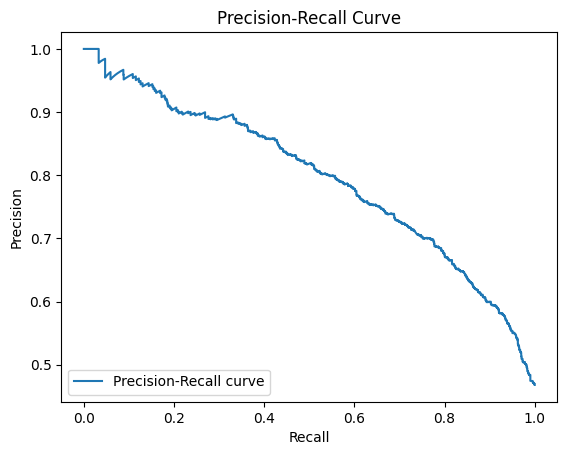

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, svm_model.decision_function(X_test))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

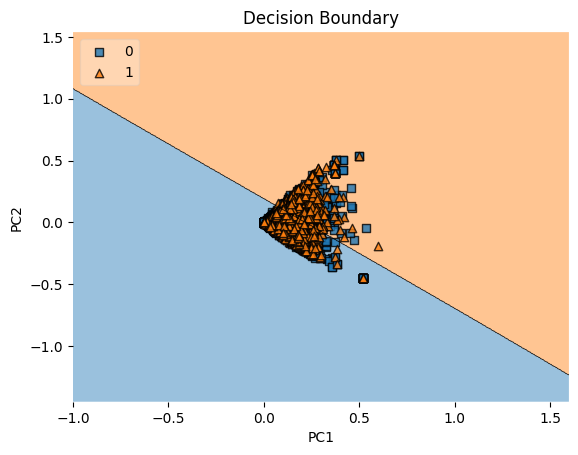

In [34]:
from sklearn.decomposition import TruncatedSVD
y_train = np.array(y_train)

# create TruncatedSVD object with desired number of components
svd = TruncatedSVD(n_components=2)

# fit and transform the training data
X_train_svd = svd.fit_transform(X_train)

# transform the test data
X_test_svd = svd.transform(X_test)

# reduce dimensionality to 2D using TruncatedSVD
svm_model = SVC(kernel='sigmoid', C=best_params['C'], gamma=best_params['gamma'])
svm_model.fit(X_train_svd, y_train)

# plot decision boundary
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X_train_svd, y_train, clf=svm_model, legend=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Decision Boundary')
plt.show()


confusion_matrix:


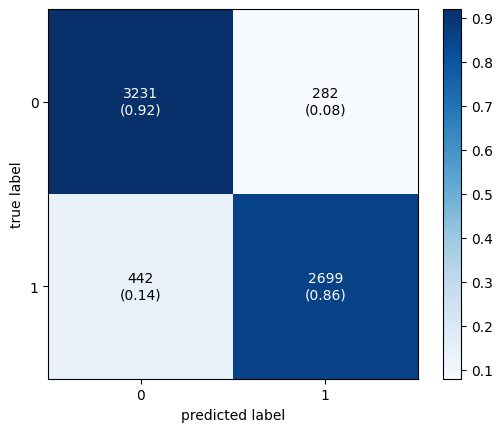


Classification Report of SVM Classifier on Training Data:

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3513
           1       0.91      0.86      0.88      3141

    accuracy                           0.89      6654
   macro avg       0.89      0.89      0.89      6654
weighted avg       0.89      0.89      0.89      6654



In [35]:
print("confusion_matrix:")
LABEL=['0','1']
conf=confusion_matrix(y_train,y_train_pred)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_train, y_train_pred),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

print("\nClassification Report of SVM Classifier on Training Data:\n")
print(classification_report(y_train, y_train_pred))

In [36]:
# import string
# import re
# import urllib.request, json
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# import numpy as np
# import joblib

# # Download Filipino stopwords
# with urllib.request.urlopen("https://raw.githubusercontent.com/stopwords-iso/stopwords-tl/master/stopwords-tl.json") as url:
#     stopwords_tl = json.loads(url.read().decode())

# def preprocess_text(text):
#     # Remove unwanted characters and digits
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     #Tokenize the text
#     tokens = word_tokenize(text)
#     # Convert tokens to lowercase
#     tokens = [word.lower() for word in tokens]
#     # Remove stopwords
#     tokens = [word for word in tokens if word.lower() not in stopwords_tl]
#     # Lemmatize the tokens
#     lemmatized_tokens = []

#     for token in tokens:
#         if wordnet.synsets(token):
#             pos = nltk.pos_tag([token])[0][1][0].lower()
#             pos = {'a': wordnet.ADJ,
#                    'n': wordnet.NOUN,
#                    'v': wordnet.VERB,
#                    'r': wordnet.ADV}.get(pos, wordnet.NOUN)
#             lemmatized_token = lemmatizer.lemmatize(token, pos)
#         else:
#             lemmatized_token = tg_stemmer([token])[0]
        
#         lemmatized_tokens.append(lemmatized_token)
        
#     # Join the tokens back into a string
#     text = ' '.join(lemmatized_tokens)
#     return text


# # Load the trained SVM model
# clf = joblib.load('svm_model.joblib')

# # Load the vectorizer fitted on the training data
# vectorizer = joblib.load('tfidf_vectorizer.joblib')

# # Get input from user
# sentiment = input("Enter a sentence to analyze: ")

# # Preprocess the input text
# sentiment_processed = preprocess_text(sentiment)

# # Vectorize the input text
# sentiment_vectorized = vectorizer.transform([sentiment_processed])

# # Predict the sentiment using the trained SVM model
# prediction = clf.predict(sentiment_vectorized)

# print(prediction)
# print(sentiment)
# # Print the prediction
# if prediction == 1:
#     print("Negative Statement")
# else:
#     print("Positive sentiment")


In [37]:
%load_ext scalene


Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.
